In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier


In [2]:
# Load data
df_raw = pd.read_csv('Spaceship data.csv')
df_raw.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## 1. שלב א - חקר נתונים (EDA)

מטרת ה-EDA להבין את מבנה הנתונים, משתנים חסרים, התפלגויות ואיזון התיוגים.


In [3]:
# Basic structure
print('Shape:', df_raw.shape)
df_raw.info()


Shape: (8693, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [4]:
# Missing values summary
missing = df_raw.isna().mean().sort_values(ascending=False)
missing[missing > 0]


CryoSleep       0.024963
ShoppingMall    0.023927
VIP             0.023352
HomePlanet      0.023122
Name            0.023007
Cabin           0.022892
VRDeck          0.021627
FoodCourt       0.021051
Spa             0.021051
Destination     0.020936
RoomService     0.020821
Age             0.020591
dtype: float64

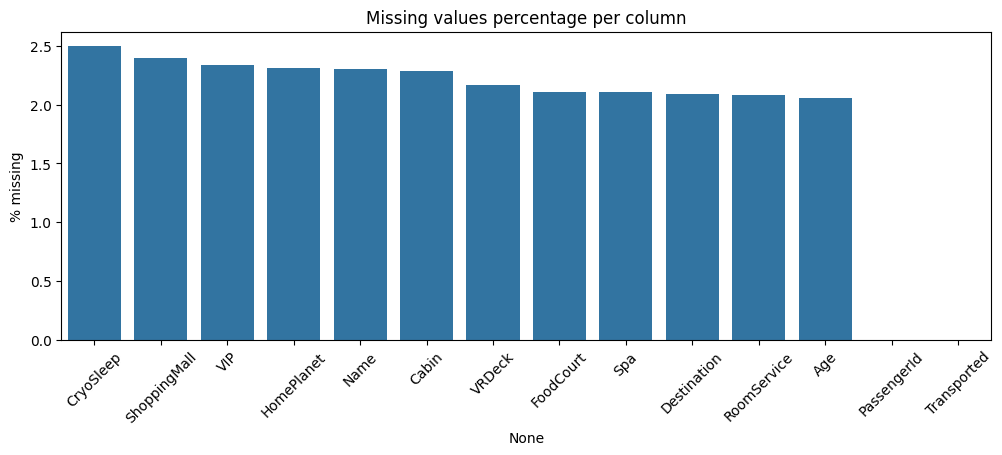

In [5]:
plt.figure(figsize=(12,4))
sns.barplot(x=missing.index, y=missing.values*100)
plt.xticks(rotation=45)
plt.ylabel('% missing')
plt.title('Missing values percentage per column')
plt.show()


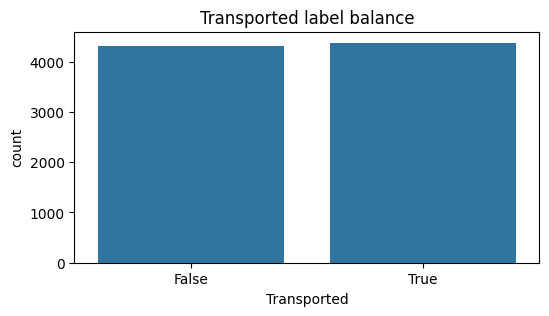

Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64


In [6]:
# Label balance
plt.figure(figsize=(6,3))
sns.countplot(data=df_raw, x='Transported')
plt.title('Transported label balance')
plt.show()

print(df_raw['Transported'].value_counts(normalize=True))


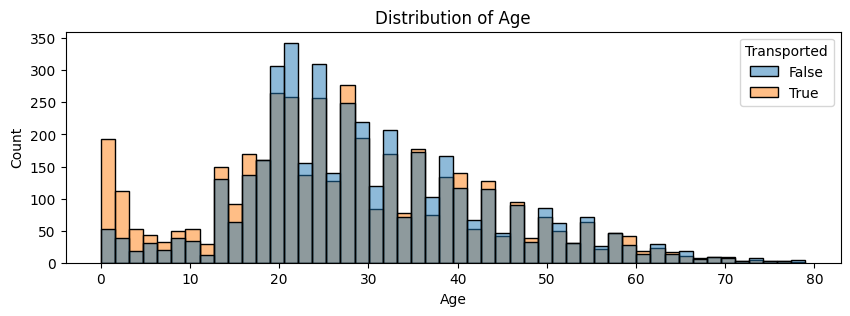

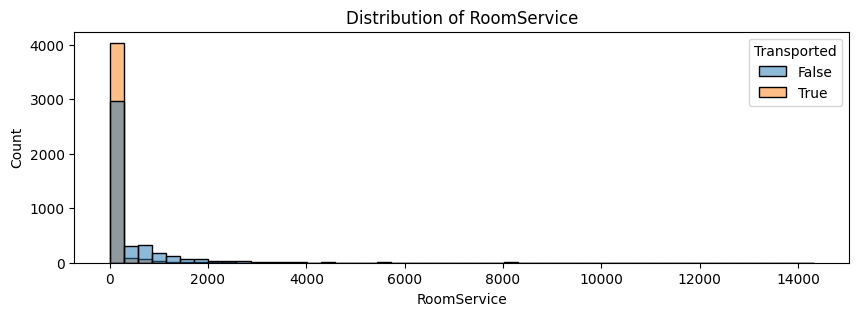

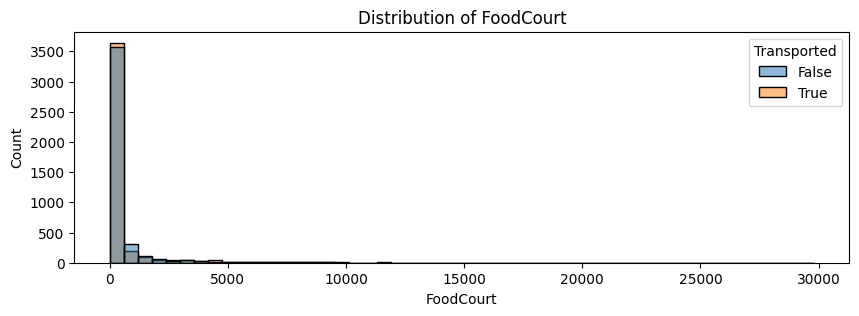

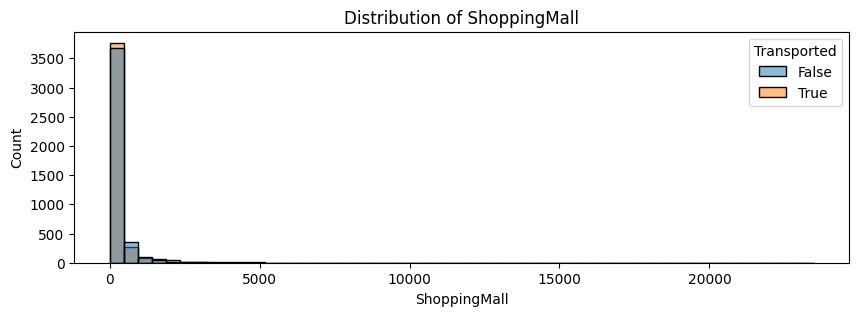

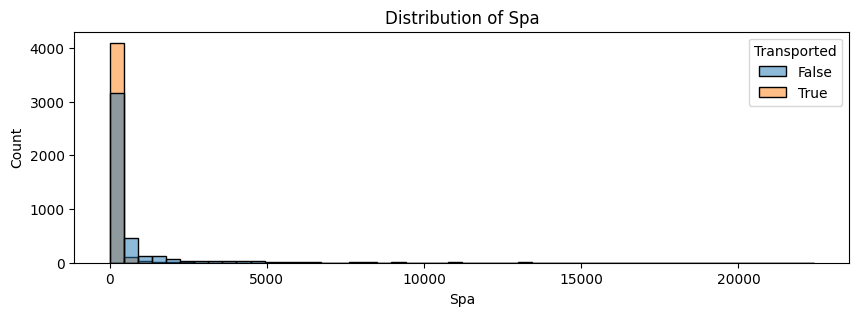

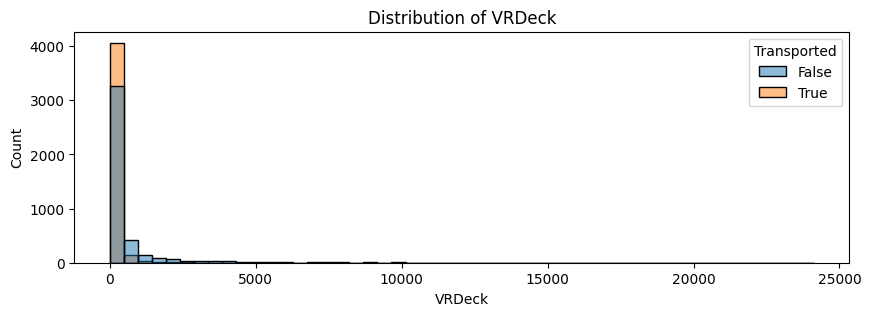

In [7]:
# Distributions - numerical
num_cols = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
for c in num_cols:
    plt.figure(figsize=(10,3))
    sns.histplot(data=df_raw, x=c, hue='Transported', bins=50, kde=False)
    plt.title(f'Distribution of {c}')
    plt.show()


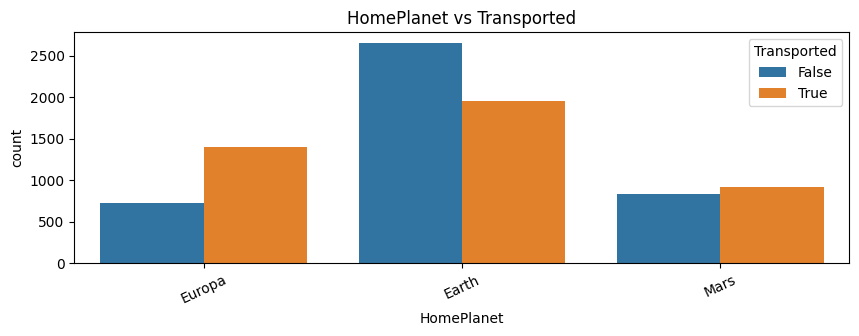

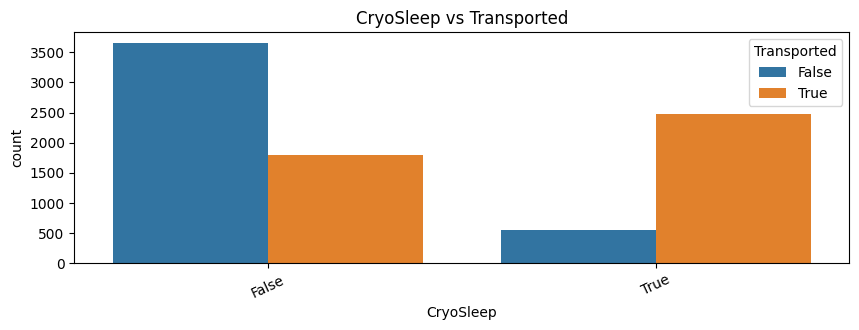

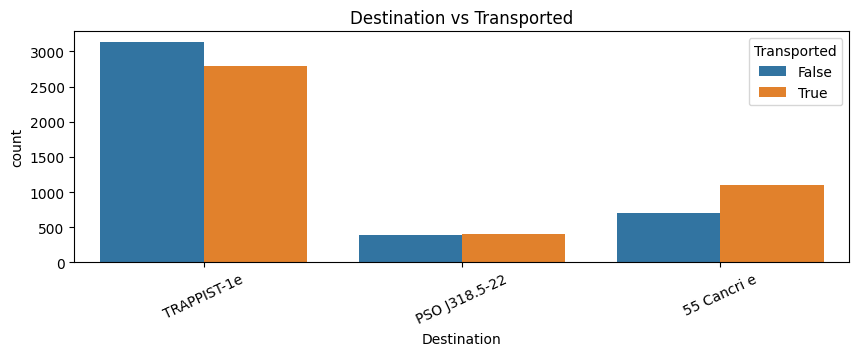

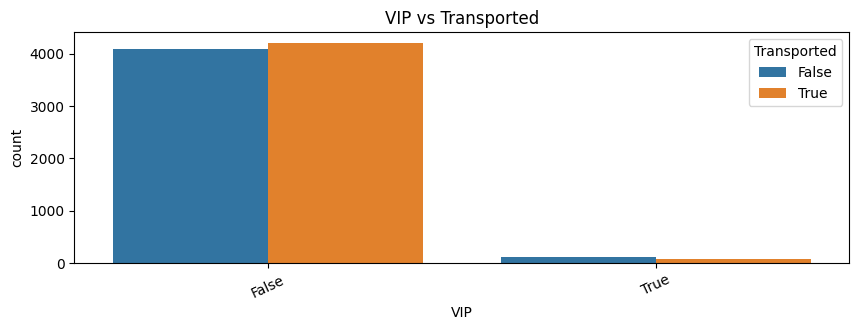

In [8]:
# Categorical vs label
cat_cols = ['HomePlanet','CryoSleep','Destination','VIP']
for c in cat_cols:
    plt.figure(figsize=(10,3))
    sns.countplot(data=df_raw, x=c, hue='Transported')
    plt.title(f'{c} vs Transported')
    plt.xticks(rotation=25)
    plt.show()


## 2. שלב ב - הכנת המידע לאימון מסווג

נקודת התיקון המרכזית: מבצעים Split ל-Train/Test לפני כל פעולה שלומדת סטטיסטיקה מהנתונים.


In [9]:
# Split early (before any statistical imputation / encoding)
X = df_raw.drop(columns=['Transported'])
y = df_raw['Transported'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

print('Train:', X_train.shape, 'Test:', X_test.shape)


Train: (6954, 13) Test: (1739, 13)


### 2.1 Preprocessing ו-Feature Engineering (ללא Leakage)

הקוד הבא מבוסס על הלוגיקה שבנית במחברת המקורית, אבל ממומש כ-Transformer כך שכל סטטיסטיקה נלמדת רק מה-Train (וב-CV רק מה-fold של ה-Train).


In [10]:
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

class TitanicFeatureBuilder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.age_median_by_hp_ = None
        self.cryo_mode_ = None
        self.pg_to_hp_ = None
        self.ln_to_hp_ = None
        self.max_cabin_num_ = None

    def _split_passenger_group(self, df):
        df = df.copy()
        df['PassengerGroup'] = df['PassengerId'].str.split('_').str[0].astype(int)
        group_sizes = df['PassengerGroup'].value_counts()
        df['GroupSize'] = df['PassengerGroup'].map(group_sizes)
        df['Solo'] = (df['GroupSize'] == 1).astype(int)
        return df

    def _split_cabin(self, df):
        df = df.copy()
        # temporary outlier to split
        df['Cabin'] = df['Cabin'].fillna('Z/9999/Z')
        cabin = df['Cabin'].str.split('/', expand=True)
        df['Cabin_deck'] = cabin[0]
        df['Cabin_number'] = pd.to_numeric(cabin[1], errors='coerce')
        df['Cabin_side'] = cabin[2]

        # restore NaNs
        df.loc[df['Cabin_deck'] == 'Z', 'Cabin_deck'] = np.nan
        df.loc[df['Cabin_number'] == 9999, 'Cabin_number'] = np.nan
        df.loc[df['Cabin_side'] == 'Z', 'Cabin_side'] = np.nan

        df = df.drop(columns=['Cabin'])
        return df

    def _split_name(self, df):
        df = df.copy()
        df['Name'] = df['Name'].fillna('Unknown Unknown')
        full = df['Name'].str.split(' ', n=1, expand=True)
        df['First_name'] = full[0]
        df['Last_name'] = full[1]
        # convert Unknown back to NaN for logic that relies on known last name
        df.loc[df['Last_name'].str.lower() == 'unknown', 'Last_name'] = np.nan
        df = df.drop(columns=['Name'])
        return df

    def _fill_homeplanet(self, df):
        df = df.copy()

        # 1) from PassengerGroup (learned on train)
        if self.pg_to_hp_ is not None:
            df.loc[df['HomePlanet'].isna(), 'HomePlanet'] = df.loc[df['HomePlanet'].isna(), 'PassengerGroup'].map(self.pg_to_hp_)

        # 2) from Cabin_deck (rule from your notebook)
        df.loc[df['HomePlanet'].isna() & df['Cabin_deck'].isin(['A','B','C','T']), 'HomePlanet'] = 'Europa'
        df.loc[df['HomePlanet'].isna() & df['Cabin_deck'].isin(['G']), 'HomePlanet'] = 'Earth'

        # 3) from Last_name (learned on train)
        if self.ln_to_hp_ is not None:
            df.loc[df['HomePlanet'].isna(), 'HomePlanet'] = df.loc[df['HomePlanet'].isna(), 'Last_name'].map(self.ln_to_hp_)

        # 4) final rule from your notebook: deck D -> Mars, else Earth
        df.loc[df['HomePlanet'].isna() & (df['Cabin_deck'] == 'D'), 'HomePlanet'] = 'Mars'
        df.loc[df['HomePlanet'].isna() & ~(df['Cabin_deck'] == 'D'), 'HomePlanet'] = 'Earth'
        return df

    def _fill_destination_vip(self, df):
        df = df.copy()
        df['Destination'] = df['Destination'].fillna('TRAPPIST-1e')
        df['VIP'] = df['VIP'].fillna(False).astype(int)
        return df

    def _fill_age_and_age_group(self, df):
        df = df.copy()
        if self.age_median_by_hp_ is not None:
            df['Age'] = df['Age'].fillna(df['HomePlanet'].map(self.age_median_by_hp_))
        # fallback in case map yields NaN (rare)
        df['Age'] = df['Age'].fillna(df['Age'].median())

        df['Age_group'] = np.nan
        df.loc[df['Age']<=13,'Age_group']='Age_0-13'
        df.loc[(df['Age']>13) & (df['Age']<=18),'Age_group']='Age_14-18'
        df.loc[(df['Age']>18) & (df['Age']<=30),'Age_group']='Age_19-30'
        df.loc[(df['Age']>30) & (df['Age']<=50),'Age_group']='Age_31-50'
        df.loc[df['Age']>50,'Age_group']='Age_51+'
        return df

    def _spend_features_and_cryo(self, df):
        df = df.copy()

        # TotalSpent and NoSpendings (as in your notebook)
        df['TotalSpent'] = df[spending_cols].sum(axis=1, skipna=True)
        df['NoSpendings'] = (df['TotalSpent'] == 0).astype(int)

        # CryoSleep logic from your notebook:
        # - if NoSpendings == False => CryoSleep cannot be True, so fill False
        cryo_filter = df['CryoSleep'].isna() & (df['NoSpendings'] == 0)
        df.loc[cryo_filter, 'CryoSleep'] = False

        # - remaining missing -> mode from train
        if self.cryo_mode_ is not None:
            df['CryoSleep'] = df['CryoSleep'].fillna(self.cryo_mode_)
        else:
            df['CryoSleep'] = df['CryoSleep'].fillna(False)

        df['CryoSleep'] = df['CryoSleep'].astype(int)

        # CryoSleep -> no expenditure (set NaN spendings to 0 when CryoSleep==1)
        for col in spending_cols:
            df.loc[df[col].isna() & (df['CryoSleep'] == 1), col] = 0

        # remaining spendings -> 0 (as in your notebook)
        df[spending_cols] = df[spending_cols].fillna(0)

        # recompute totals
        df['TotalSpent'] = df[spending_cols].sum(axis=1)
        df['NoSpendings'] = (df['TotalSpent'] == 0).astype(int)
        return df

    def _fill_cabin_by_group(self, df):
        # Fill Cabin_deck/number/side inside PassengerGroup only using rows available in the same split (no cross-split leakage)
        df = df.copy()
        for _, g in df.groupby('PassengerGroup'):
            if len(g) <= 1:
                continue

            # deck
            known = g['Cabin_deck'].dropna().unique()
            if len(known) == 1:
                df.loc[g.index, 'Cabin_deck'] = g['Cabin_deck'].fillna(known[0])

            # number
            known = g['Cabin_number'].dropna().unique()
            if len(known) == 1:
                df.loc[g.index, 'Cabin_number'] = g['Cabin_number'].fillna(known[0])

            # side
            known = g['Cabin_side'].dropna().unique()
            if len(known) == 1:
                df.loc[g.index, 'Cabin_side'] = g['Cabin_side'].fillna(known[0])

        # Fill remaining with constants that depend on train max (for Cabin_number)
        if self.max_cabin_num_ is None:
            self.max_cabin_num_ = int(np.nanmax(df['Cabin_number']))
        df['Cabin_number'] = df['Cabin_number'].fillna(self.max_cabin_num_ + 1)

        df['Cabin_deck'] = df['Cabin_deck'].fillna('unknown')
        df['Cabin_side'] = df['Cabin_side'].fillna('unknown')
        return df

    def _cabin_regions(self, df):
        df = df.copy()
        max_cabin_num = self.max_cabin_num_
        df['Cabin_region1']=(df['Cabin_number']<300).astype(int)
        df['Cabin_region2']=((df['Cabin_number']>=300) & (df['Cabin_number']<600)).astype(int)
        df['Cabin_region3']=((df['Cabin_number']>=600) & (df['Cabin_number']<900)).astype(int)
        df['Cabin_region4']=((df['Cabin_number']>=900) & (df['Cabin_number']<1200)).astype(int)
        df['Cabin_region5']=((df['Cabin_number']>=1200) & (df['Cabin_number']<1500)).astype(int)
        df['Cabin_region6']=((df['Cabin_number']>=1500) & (df['Cabin_number']<=max_cabin_num)).astype(int)
        df['Cabin_region_unknown']=(df['Cabin_number']>max_cabin_num).astype(int)
        return df

    def fit(self, X, y=None):
        df = X.copy()

        df = self._split_passenger_group(df)
        df = self._split_cabin(df)
        df = self._split_name(df)

        # learn mappings for HomePlanet fills (PassengerGroup / Last_name)
        tmp = df[['PassengerGroup','HomePlanet']].dropna()
        unique_hp_per_group = tmp.groupby('PassengerGroup')['HomePlanet'].nunique()
        single_groups = unique_hp_per_group[unique_hp_per_group == 1].index
        self.pg_to_hp_ = tmp[tmp['PassengerGroup'].isin(single_groups)].groupby('PassengerGroup')['HomePlanet'].first()

        tmp = df[['Last_name','HomePlanet']].dropna()
        unique_hp_per_ln = tmp.groupby('Last_name')['HomePlanet'].nunique()
        single_ln = unique_hp_per_ln[unique_hp_per_ln == 1].index
        self.ln_to_hp_ = tmp[tmp['Last_name'].isin(single_ln)].groupby('Last_name')['HomePlanet'].first()

        # Apply homeplanet so we can learn Age medians by HomePlanet
        df = self._fill_homeplanet(df)

        self.age_median_by_hp_ = df.groupby('HomePlanet')['Age'].median()

        # Cryo mode learned from train
        if df['CryoSleep'].dropna().shape[0] > 0:
            self.cryo_mode_ = bool(df['CryoSleep'].mode()[0])
        else:
            self.cryo_mode_ = False

        # For Cabin_number fill, compute max from train after group-based fills
        df = self._fill_cabin_by_group(df)
        self.max_cabin_num_ = int(np.nanmax(df['Cabin_number']))

        return self

    def transform(self, X):
        df = X.copy()

        df = self._split_passenger_group(df)
        df = self._split_cabin(df)
        df = self._split_name(df)

        df = self._fill_homeplanet(df)
        df = self._fill_destination_vip(df)
        df = self._fill_age_and_age_group(df)
        df = self._spend_features_and_cryo(df)

        df = self._fill_cabin_by_group(df)
        df = self._cabin_regions(df)

        # Drop features you removed before modeling in the original notebook
        drop_cols = ['PassengerId','First_name','Last_name','Cabin_number','NoSpendings','Solo']
        df = df.drop(columns=[c for c in drop_cols if c in df.columns])

        return df


In [11]:
# Define preprocessing (feature builder + one-hot encoding for selected categorical columns)
feature_builder = TitanicFeatureBuilder()

categorical_cols = ['HomePlanet','Destination','Cabin_deck','Cabin_side','Age_group']
# numerical columns = everything else after feature_builder
# We will one-hot only categorical cols and pass-through the rest.

preprocess = Pipeline(steps=[
    ('features', feature_builder),
    ('encode', ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ],
        remainder='passthrough'
    ))
])


## 3. שלב ג - אימון מסווגים ובחירת המסווג המיטבי

Cross-Validation מבוצע רק על סדרת האימון (X_train, y_train). כל preprocessing נמצא בתוך Pipeline ולכן אין Leakage גם בתוך ה-folds.


In [12]:
models = {
    "KNN": KNeighborsClassifier(),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "GNB": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(random_state=0),
    "SVM": SVC(probability=True, random_state=0),
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler(with_mean=False)),  # with_mean=False because sparse output after OHE
        ('clf', LogisticRegression(max_iter=5000, solver='lbfgs'))
    ]),
    "MLP": Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', MLPClassifier(random_state=0, max_iter=2000))
    ]),
    "XGBoost (sklearn GBDT)": GradientBoostingClassifier(random_state=0)
}


In [13]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=0)
scoring = ['accuracy', 'precision', 'recall', 'roc_auc']

cv_results = {}
for name, model in models.items():
    if isinstance(model, Pipeline) and 'clf' in dict(model.named_steps):
        clf = Pipeline(steps=[('preprocess', preprocess), ('model', model)])
    else:
        clf = Pipeline(steps=[('preprocess', preprocess), ('model', model)])
    scores = cross_validate(clf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    cv_results[name] = {m: scores[f'test_{m}'].mean() for m in scoring}

results_df = pd.DataFrame(cv_results).T
results_df = results_df.sort_values('roc_auc', ascending=False)
results_df


KeyboardInterrupt: 

In [ ]:
# Best model according to ROC AUC
best_name = results_df['roc_auc'].idxmax()
print('Best model by ROC AUC:', best_name)
results_df.loc[best_name]


## 4. הערכה סופית על Test (Holdout)

מאמנים את המודל הנבחר על כל ה-Train ומעריכים פעם אחת על ה-Test שהופרד מראש.


In [ ]:
best_model = models[best_name]
final_clf = Pipeline(steps=[('preprocess', preprocess), ('model', best_model)])
final_clf.fit(X_train, y_train)

# Probabilities for ROC curve
y_proba = final_clf.predict_proba(X_test)[:,1]
y_pred = (y_proba >= 0.5).astype(int)

test_auc = roc_auc_score(y_test, y_proba)
print('Test ROC AUC:', round(test_auc, 4))


In [ ]:
# ROC curve
fpr, tpr, thr = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_name} (AUC={test_auc:.3f})')
plt.show()


In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(values_format='d')
plt.title(f'Confusion Matrix - {best_name}')
plt.show()


## 5. הערות על התיקון

- ה-Split בוצע לפני כל פעולה שלומדת סטטיסטיקה.
- כל ה-preprocessing נמצא בתוך Pipeline ולכן גם בתוך Cross-Validation אין leakage.
- הלוגיקה של השלמות ו-feature engineering היא אותה לוגיקה מהמחברת המקורית, אך הועברה ל-Transformer עם fit/transform.
